In [8]:
import numpy as np
import tensorflow as tf
import Loader
import Transformer
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.style.use('dark_background')

In [5]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

## SVM for Regression (aka SVR)

In [42]:
from sklearn import svm
from sklearn.metrics import mean_squared_error

maxC = 10
svrModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)

svrModel.fit(trainData, activitiesTrain)
trainPred = svrModel.predict(trainData)
valPred = svrModel.predict(valData)
testPred = svrModel.predict(testData)

print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
#print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often

Ein Error:  0.35543153907321473
Eval Error:  2.215028353321067


## NN Regression

In [ ]:
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

history = model.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
    epochs=50, batch_size=10, verbose = 1) #verbose = 0 for no printing

Epoch 1/50
272/272 [==============================] - 6s 15ms/step - loss: 21.6470 - mean_squared_error: 4.3187 - val_loss: 14.2609 - val_mean_squared_error: 2.8579
Epoch 2/50
272/272 [==============================] - 4s 14ms/step - loss: 11.7158 - mean_squared_error: 2.5258 - val_loss: 10.4802 - val_mean_squared_error: 3.0016
Epoch 3/50
272/272 [==============================] - 4s 14ms/step - loss: 8.5497 - mean_squared_error: 2.1484 - val_loss: 7.8635 - val_mean_squared_error: 2.3503
Epoch 4/50
272/272 [==============================] - 4s 14ms/step - loss: 6.6797 - mean_squared_error: 1.8102 - val_loss: 7.1759 - val_mean_squared_error: 2.8316
Epoch 5/50
272/272 [==============================] - 3s 12ms/step - loss: 5.4321 - mean_squared_error: 1.5083 - val_loss: 6.1418 - val_mean_squared_error: 2.5943
Epoch 6/50
272/272 [==============================] - 3s 12ms/step - loss: 4.7474 - mean_squared_error: 1.4778 - val_loss: 5.6358 - val_mean_squared_error: 2.6029
Epoch 7/50
272/272

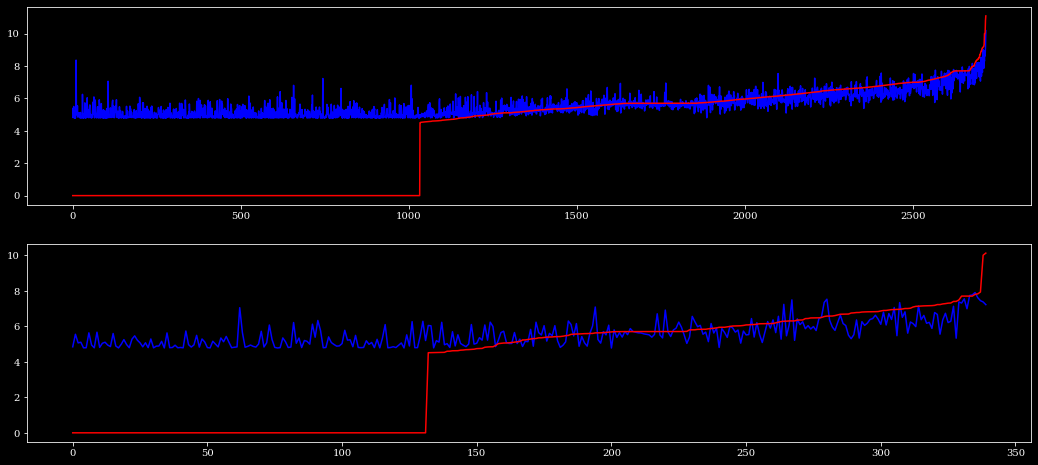

In [115]:
fig, ax = plt.subplots(2, figsize=(18,8))

trainPred = model.predict(trainData).flatten()
valPred = model.predict(valData).flatten()

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], color="blue")
ax[0].plot(activitiesTrain[trainOrder], color="red")
ax[1].plot(valPred[valOrder], color="blue")
ax[1].plot(activitiesValidate[valOrder], color="red")

## Bah humbug, terrible performance
New method, use SVM (our best predictor) for classification, then if classified as low activity give it a zero, otherwise use any high activity and then use svm (or more correctly SVR) to classify high activity, should reduce error significantly

In [14]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

trainClass = Transformer.toBinaryClassification(activitiesTrain)
testClass = Transformer.toBinaryClassification(activitiesTest)
valClass = Transformer.toBinaryClassification(activitiesValidate)

In [59]:
#create svm model
from sklearn import svm
from sklearn.metrics import accuracy_score

maxC = 10
binModel =svm.SVC(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
    break_ties=False,               # How to handle breaking ties
)
binModel.fit(trainData, trainClass) #binary classification using svm

highActMask = trainClass == 1 #all the high activity data points

#now run an SVR on the high activity data
maxC = 1
regModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)
regModel.fit(trainData[highActMask], activitiesTrain[highActMask]); #regression model only on high activity

In [64]:
#alternate regression model
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
nnRegr = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

nnRegr.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

highActMask = trainClass == 1 #all the high activity data points

history = nnRegr.fit(trainData[highActMask], activitiesTrain[highActMask], 
    epochs=50, batch_size=10, verbose = 1) #verbose = 0 for no printing

Epoch 1/25
169/169 [==============================] - 2s 4ms/step - loss: 16.2615 - mean_squared_error: 2.0469
Epoch 2/25
169/169 [==============================] - 1s 4ms/step - loss: 10.9101 - mean_squared_error: 0.7841
Epoch 3/25
169/169 [==============================] - 1s 4ms/step - loss: 8.3243 - mean_squared_error: 0.5746
Epoch 4/25
169/169 [==============================] - 1s 4ms/step - loss: 6.6605 - mean_squared_error: 0.5861
Epoch 5/25
169/169 [==============================] - 1s 4ms/step - loss: 5.3600 - mean_squared_error: 0.5278
Epoch 6/25
169/169 [==============================] - 1s 4ms/step - loss: 4.3986 - mean_squared_error: 0.5113
Epoch 7/25
169/169 [==============================] - 1s 4ms/step - loss: 3.6091 - mean_squared_error: 0.4523
Epoch 8/25
169/169 [==============================] - 1s 4ms/step - loss: 3.0501 - mean_squared_error: 0.4693
Epoch 9/25
169/169 [==============================] - 1s 4ms/step - loss: 2.5079 - mean_squared_error: 0.3945
Epoch 10

In [97]:
def evalData(inputData, svmModel, svrModel, zeroGuess=0): #given the models and data points evaluate
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = svrModel.predict(inputData[binaryClass == 1]) #regression high activity prediction
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred

def evalData2(inputData, svmModel, nnModel, zeroGuess=0): #same as above but use NN for regr
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = nnModel.predict(inputData[binaryClass == 1]).flatten() #high activity regr predict
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred
    
zGuess = .6
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
print('')
print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred2))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred2))

#only if we're testing test data
#print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often

Ein Error:  0.3166837661028402
Eval Error:  2.248902381467032

Ein Error:  0.3505086188465643
Eval Error:  2.2256534042055542


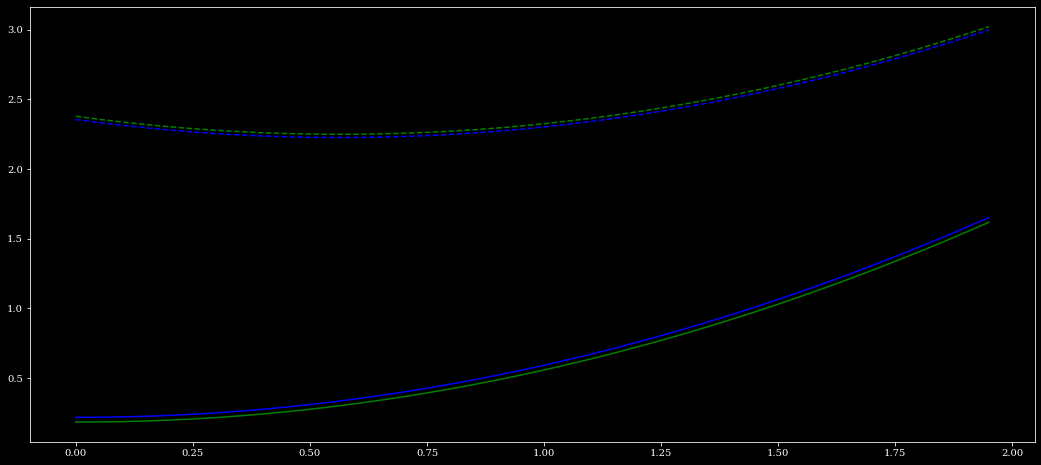

In [96]:
zGuesses = np.arange(0,2,.05)
trainErrorS = [] #SVM regr
valErrorS = [] #SVM regr
trainErrorN = [] #NN regr
valErrorN = [] #NN regr

for zG in zGuesses:
    trainPredS = evalData(trainData, binModel, regModel, zeroGuess=zG)
    valPredS = evalData(valData, binModel, regModel, zeroGuess=zG)
    trainPredN = evalData2(trainData, binModel, nnRegr, zeroGuess=zG)
    valPredN = evalData2(valData, binModel, nnRegr, zeroGuess=zG)
    
    trainErrorS.append(mean_squared_error(activitiesTrain, trainPredS))
    valErrorS.append(mean_squared_error(activitiesValidate, valPredS))
    trainErrorN.append(mean_squared_error(activitiesTrain, trainPredN))
    valErrorN.append(mean_squared_error(activitiesValidate, valPredN))
    
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(zGuesses, trainErrorS, color="green")
ax.plot(zGuesses, valErrorS, color="green", linestyle="dashed")
ax.plot(zGuesses, trainErrorN, color="blue")
ax.plot(zGuesses, valErrorN, color="blue", linestyle="dashed")

## Getting an idea of prediction accuracy

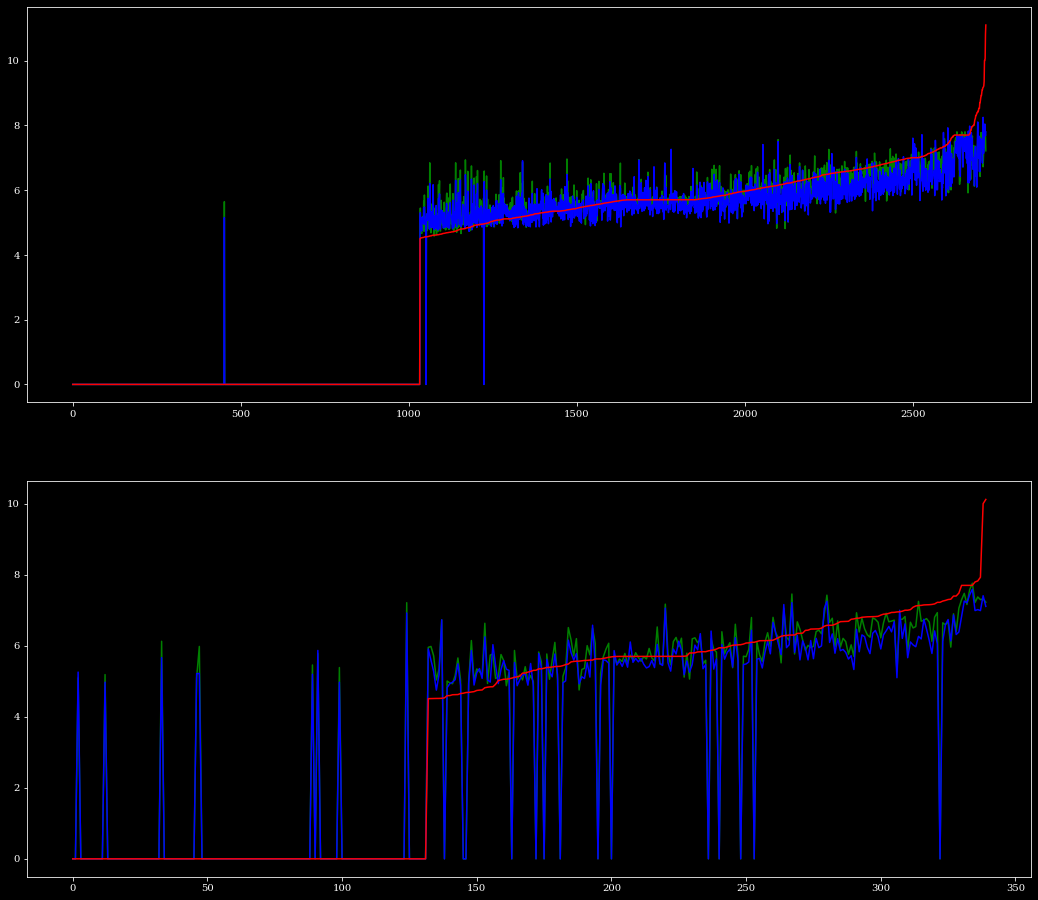

In [112]:
zGuess = 0
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], color="green")
ax[0].plot(trainPred2[trainOrder], color="blue")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred[valOrder], color="green")
ax[1].plot(valPred2[valOrder], color="blue")
ax[1].plot(activitiesValidate[valOrder], color="red")

In [102]:
a1 = np.array([[0,0],[1,1],[2,3],[3,0],[4,5]])
a2 = np.array([3,4,2,1,5])

sortOrder = np.argsort(a2)
print(a1[sortOrder])
print(a2[sortOrder])

[[3 0]
 [2 3]
 [0 0]
 [1 1]
 [4 5]]
[1 2 3 4 5]
